In [1]:
from collections import defaultdict
import gymnasium as gym
import numpy as np


class BlackjackAgent:
    def __init__(
        self,
        env: gym.Env,
        lr_bet: float,
        lr_play: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Q-Learning agent.

        Args:
            env: The training environment
            lr_bet: How quickly to update Q-values in the betting phase (0-1)
            lr_play: How quickly to update Q-values in the playing phase (0-1)
            initial_epsilon: Starting exploration rate (usually 1.0)
            epsilon_decay: How much to reduce epsilon each episode
            final_epsilon: Minimum exploration rate (usually 0.1)
            discount_factor: How much to value future rewards (0-1)
        """
        base = getattr(env, "unwrapped", env)
        self.env = env

        # Spaces
        self.n_bets = int(base.n_bets)
        self.n_tc = int(base.observation_space.spaces[3].n)

        # Q_bet[tc_bucket, n_bets]
        self.Q_bet = np.zeros((self.n_tc, self.n_bets), dtype=np.float32)

        # Q_play[player_sum(32), dealer(11), usable(2), tc_bucket, 2]
        self.Q_play = np.zeros((32, 11, 2, self.n_tc, 2), dtype=np.float32)

        self.lr_bet = lr_bet
        self.lr_play = lr_play
        self.discount_factor = discount_factor  # How much we care about future rewards

        # Exploration parameters
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        # Track learning progress
        self.training_error_bet = []
        self.training_error_play = []

        self.rng = np.random.default_rng()

    # ---------- indexing helpers ----------
    @staticmethod
    def _unpack(obs):
        # obs = (psum, dealer, usable, tc_idx, phase)
        return int(obs[0]), int(obs[1]), int(obs[2]), int(obs[3]), int(obs[4])

    def _idxs_play(self, obs):
        # obs = (psum, dealer, usable, tc_idx, phase)
        ps, dv, ua, tc, _ = self._unpack(obs)
        return ps, dv, ua, tc

    # ---------- ε-greedy policies ----------
    def select_bet(self, obs):
        # obs phase must be 0
        tc_idx = int(obs[3])
        q = self.Q_bet[tc_idx]
        if self.rng.random() < self.epsilon:
            return int(self.rng.integers(self.n_bets))
        # argmax with random tie-break
        m = q.max(); idxs = np.flatnonzero(q == m)
        return int(self.rng.choice(idxs))

    def select_play(self, obs):
        # obs phase must be 1
        ps, dv, ua, tc = self._idxs_play(obs)
        q = self.Q_play[ps, dv, ua, tc]
        if self.rng.random() < self.epsilon:
            return int(self.rng.integers(2))   # 0=stick, 1=hit
        m = q.max(); idxs = np.flatnonzero(q == m)
        return int(self.rng.choice(idxs))
    
    # ---------- Q-Learning updates ----------
    def update_bet_q_learning(self, s0, a_bet, r0, s1):
        # r0 is 0 in env; bootstrap through first play-state/action
        tc0 = int(s0[3])
        qsa = self.Q_bet[tc0, a_bet]
        target = r0 + self.discount_factor * np.max(self.Q_play[self._idxs_play(s1)])
        td = target - qsa
        self.Q_bet[tc0, a_bet] += self.lr_bet * td
        self.training_error_bet.append(td)

    def update_bet_mc(self, s0, a_bet, G):
        # optional Monte-Carlo kick at episode end with full return
        tc0 = int(s0[3])
        qsa = self.Q_bet[tc0, a_bet]
        td = G - qsa
        self.Q_bet[tc0, a_bet] += self.lr_bet * td
        self.training_error_bet.append(td)

    def update_play_q_learning(self, s, a, r, done, s_next=None):
        ps, dv, ua, tc = self._idxs_play(s)
        qsa = self.Q_play[ps, dv, ua, tc, a]
        if done:
            target = r
        else:
            ps2, dv2, ua2, tc2 = self._idxs_play(s_next)
            target = r + self.discount_factor * np.max(self.Q_play[ps2, dv2, ua2, tc2])
        td = target - qsa
        self.Q_play[ps, dv, ua, tc, a] += self.lr_play * td
        self.training_error_play.append(td)

    # ---------- epsilon schedule ----------
    def decay_epsilon(self):
        """Reduce exploration rate after each episode."""
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

    # ---------- greedy (masked) for evaluation ----------
    def greedy_bet(self, obs):
        tc = int(obs[3]); q = self.Q_bet[tc]
        m = q.max(); idxs = np.flatnonzero(q == m)
        return int(self.rng.choice(idxs))

    def greedy_play(self, obs):
        ps, dv, ua, tc = self._idxs_play(obs)
        q = self.Q_play[ps, dv, ua, tc]
        m = q.max(); idxs = np.flatnonzero(q == m)
        return int(self.rng.choice(idxs))

In [2]:
from env import BlackjackEnv

# Training hyperparameters
# learning_rate = 0.01        # How fast to learn (higher = faster but less stable) 
lr_bet = 0.1
lr_play = 0.01
n_episodes = 5_000_000        # Number of hands to practice
start_epsilon = 1.0         # Start with 100% random actions
epsilon_decay = start_epsilon / (n_episodes / 2)  # Reduce exploration over time
final_epsilon = 0.1         # Always keep some exploration

# Create environment and agent
env = BlackjackEnv(num_decks=2, natural=True, tc_min=-20, tc_max=20)
tc_min, tc_max = env.tc_min, env.tc_max
print(tc_min)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = BlackjackAgent(
    env=env,
    lr_bet=lr_bet,
    lr_play=lr_play,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

-20


In [3]:
import numpy as np
from tqdm import tqdm  # Progress bar

n_buckets = env.observation_space.spaces[3].n
hist_start = np.zeros(n_buckets, dtype=np.int64)

for episode in tqdm(range(n_episodes)):
    # ----- Phase 0: choose bet -----
    s0, _ = env.reset()
    tc_idx = s0[3]                     # integer in [0, n_buckets-1]
    hist_start[tc_idx] += 1
    a_bet = agent.select_bet(s0)
    s1, r0, term, trunc, _ = env.step(a_bet)
    assert s1[4] == 1 and not (term or trunc)

    # Q-Learning update for the bet
    # agent.update_bet_q_learning(s0, a_bet, r0, s1)

    # ----- Phase 1: play hand -----
    G = 0.0
    s = s1
    while True:
        action = agent.select_play(s)
        s_next, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        G += reward
        agent.update_play_q_learning(s, action, reward, done, None if done else s_next)
        if done:
            break
        s = s_next

    agent.update_bet_mc(s0, a_bet, G)

    # Reduce exploration rate (agent becomes less random over time)
    agent.decay_epsilon()

# Pretty print
names = getattr(env.unwrapped, "tc_bucket_names", ("≤-3","-2","-1","0","+1","+2","≥+3"))
labels = np.array(names)
for b, c in zip(labels, hist_start):
    print(f"TC {b}: {c}")
print("coverage %:", np.round(100 * hist_start / hist_start.sum(), 2))


100%|██████████| 5000000/5000000 [05:21<00:00, 15551.81it/s]

TC ≤-3: 972779
TC -2: 358777
TC -1: 521608
TC 0: 1434731
TC +1: 473052
TC +2: 333151
TC ≥+3: 905902
coverage %: [19.46  7.18 10.43 28.69  9.46  6.66 18.12]


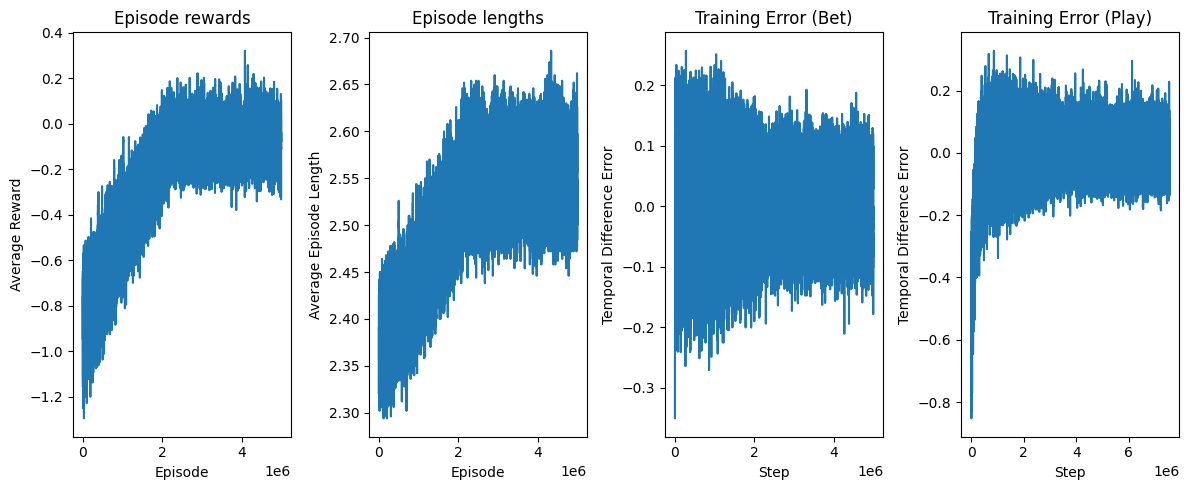

In [4]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    """Compute moving average to smooth noisy data."""
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500-episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=4, figsize=(12, 5))

# Episode rewards (win/loss performance)
axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Episode")

# Episode lengths (how many actions per hand)
axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_ylabel("Average Episode Length")
axs[1].set_xlabel("Episode")

# Training error (how much we're still learning)
axs[2].set_title("Training Error (Bet)")
training_error_bet_moving_average = get_moving_avgs(
    agent.training_error_bet,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_bet_moving_average)), training_error_bet_moving_average)
axs[2].set_ylabel("Temporal Difference Error")
axs[2].set_xlabel("Step")

axs[3].set_title("Training Error (Play)")
training_error_play_moving_average = get_moving_avgs(
    agent.training_error_play,
    rolling_length,
    "same"
)
axs[3].plot(range(len(training_error_play_moving_average)), training_error_play_moving_average)
axs[3].set_ylabel("Temporal Difference Error")
axs[3].set_xlabel("Step")

plt.tight_layout()
# Save as PNG into your Drive folder
plt.savefig('Q-Learning_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# # Test the trained agent
# def test_agent(agent, env, num_episodes=1000):
#     """Test agent performance without learning or exploration."""
#     total_rewards = []

#     # Temporarily disable exploration for testing
#     old_epsilon = agent.epsilon
#     agent.epsilon = 0.0  # Pure exploitation

#     for _ in range(num_episodes):
#         obs, info = env.reset()
#         episode_reward = 0
#         done = False

#         while not done:
#             action = agent.get_action(obs)
#             obs, reward, terminated, truncated, info = env.step(action)
#             episode_reward += reward
#             done = terminated or truncated

#         total_rewards.append(episode_reward)

#     # Restore original epsilon
#     agent.epsilon = old_epsilon

#     win_rate = np.mean(np.array(total_rewards) > 0)
#     average_reward = np.mean(total_rewards)

#     print(f"Test Results over {num_episodes} episodes:")
#     print(f"Win Rate: {win_rate:.1%}")
#     print(f"Average Reward: {average_reward:.3f}")
#     print(f"Standard Deviation: {np.std(total_rewards):.3f}")

# # Test your agent
# test_agent(agent, env, num_episodes=15000)

In [6]:
def evaluate_bankroll(agent, env, episodes=200_000, rng=None):
    rng = rng or np.random.default_rng()
    returns = np.empty(episodes, dtype=np.float64)
    total_bet = 0.0
    wins = losses = pushes = 0

    for ep in range(episodes):
        s0, _ = env.reset()                    # phase 0 (bet)
        a_bet = agent.greedy_bet(s0)
        bet = float(env.unwrapped.bet_multipliers[int(a_bet) % env.unwrapped.n_bets])
        total_bet += bet

        # play hand
        s, _ = env.step(a_bet)[:2]
        done = False; G = 0.0
        while not done:
            a = agent.greedy_play(s)
            s, r, term, trunc, _ = env.step(a)
            G += r; done = term or trunc

        returns[ep] = G
        if G > 0: wins += 1
        elif G < 0: losses += 1
        else: pushes += 1

    ev = returns.mean()                        # units/hand
    se = returns.std(ddof=1) / np.sqrt(episodes)
    ci = (ev - 1.96*se, ev + 1.96*se)
    roi = ev / (total_bet / episodes)          # profit per unit bet

    summary = {
        "hands": episodes,
        "bankroll_change": returns.sum(),
        "ev_per_hand": ev,
        "ev_95%_CI": ci,
        "avg_bet": total_bet / episodes,
        "roi_per_hand": roi,
        "win_rate": wins / episodes,
        "loss_rate": losses / episodes,
        "push_rate": pushes / episodes,
    }
    return summary

results = evaluate_bankroll(agent, env)
print(results)

{'hands': 200000, 'bankroll_change': np.float64(-8701.5), 'ev_per_hand': np.float64(-0.0435075), 'ev_95%_CI': (np.float64(-0.04923897434493869), np.float64(-0.03777602565506131)), 'avg_bet': 1.264625, 'roi_per_hand': np.float64(-0.03440347929228032), 'win_rate': 0.428165, 'loss_rate': 0.479945, 'push_rate': 0.09189}


TC ≤-3: mean=-0.1102  n=39058
TC -2: mean=-0.0846  n=14487
TC -1: mean=-0.0347  n=20944
TC 0: mean=-0.0272  n=57374
TC +1: mean=-0.0187  n=18561
TC +2: mean=-0.0219  n=13307
TC ≥+3: mean= 0.0060  n=36269


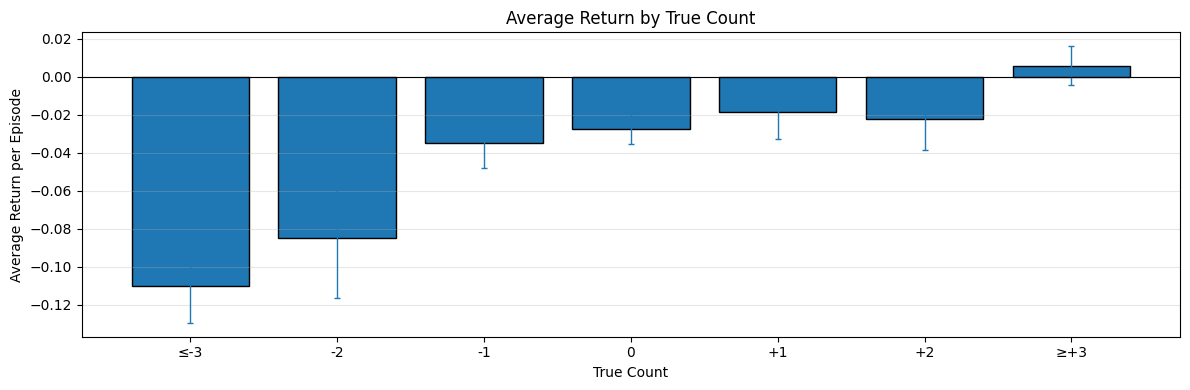

In [7]:
import numpy as np
from matplotlib import pyplot as plt

def eval_avg_return_by_tc(agent, env, episodes=200_000, greedy=True, rng=None):
    """
    Returns (labels, mean, (ci_lo, ci_hi), counts)
      labels: 1D array of TC values (tc_min..tc_max)
      mean:   avg return per hand for each TC bucket
      ci:     95% confidence intervals for each bucket
      counts: number of episodes that started in each TC bucket
    """
    rng = rng or np.random.default_rng()
    base = getattr(env, "unwrapped", env)
    n_buckets = env.observation_space.spaces[3].n
    names = getattr(env.unwrapped, "tc_bucket_names", ("≤-3","-2","-1","0","+1","+2","≥+3"))
    labels = np.array(names)  # for pretty ticks
    n_buckets = env.observation_space.spaces[3].n

    ret_sum   = np.zeros(n_buckets, dtype=np.float64)
    ret_sumsq = np.zeros(n_buckets, dtype=np.float64)
    counts    = np.zeros(n_buckets, dtype=np.int64)

    # freeze exploration for eval (if your agent has epsilon)
    old_eps = getattr(agent, "epsilon", None)
    if greedy and old_eps is not None:
        agent.epsilon = 0.0

    def pick_action(obs):
        # Single-table agent with masking helpers
        if hasattr(agent, "_valid_action_indices") and hasattr(agent, "_argmax_over"):
            if greedy:
                idxs = agent._valid_action_indices()
                q = agent.q_values[obs]
                return int(agent._argmax_over(q, idxs))
            else:
                return int(agent.get_action(obs))
        # Split agent API (two Q tables)
        if hasattr(agent, "greedy_bet") and hasattr(agent, "greedy_play"):
            return int(agent.greedy_bet(obs) if obs[4] == 0 else agent.greedy_play(obs))
        # Fallback
        return int(agent.get_action(obs))

    for _ in range(episodes):
        obs, _ = env.reset()           # phase 0; obs[3] is the TC bucket index
        tc_idx = int(obs[3])

        # Play the full hand with the current policy (greedy or epsilon-greedy)
        done = False
        G = 0.0
        while not done:
            a = pick_action(obs)
            obs, r, term, trunc, _ = env.step(a)
            G += r
            done = term or trunc

        # Aggregate by start-of-hand TC
        ret_sum[tc_idx]   += G
        ret_sumsq[tc_idx] += G * G
        counts[tc_idx]    += 1

    if greedy and old_eps is not None:
        agent.epsilon = old_eps

    # Means and 95% CIs per bucket
    denom = np.maximum(counts, 1)
    mean = ret_sum / denom
    var  = (ret_sumsq / denom) - mean**2
    se   = np.sqrt(np.maximum(var, 0.0) / denom)
    ci_lo = mean - 1.96 * se
    ci_hi = mean + 1.96 * se
    return labels, mean, (ci_lo, ci_hi), counts

def plot_avg_return_by_tc(labels, mean, ci, counts, min_visits=1000):
    ci_lo, ci_hi = ci
    mask = counts >= min_visits
    x = np.arange(n_buckets); y = mean[mask]
    yerr = np.vstack((y - ci_lo[mask], ci_hi[mask] - y))

    plt.figure(figsize=(12, 4))
    plt.bar(x, y, edgecolor='k')
    plt.xticks(x, labels)
    plt.errorbar(x, y, yerr=yerr, fmt='none', capsize=2, linewidth=1)
    plt.axhline(0, color='k', linewidth=0.8)
    plt.xlabel('True Count')
    plt.ylabel('Average Return per Episode')
    plt.title('Average Return by True Count')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

labels, mean, ci, counts = eval_avg_return_by_tc(agent, env, episodes=200_000, greedy=True)
for L, m, n in zip(labels, mean, counts):
    if n: print(f"TC {L}: mean={m: .4f}  n={n}")
plot_avg_return_by_tc(labels, mean, ci, counts, min_visits=1000)


,TC_idx,TC,best_bet_action,bet_multiplier,visits_at_start,Q_bets
0,0,≤-3,1,2.0,972779,"[-0.6085043549537659, -0.5733126997947693, -1...."
1,1,-2,1,2.0,358777,"[-0.705564022064209, -0.5555843114852905, -0.7..."
2,2,-1,0,1.0,521608,"[-0.06867550313472748, -0.5819478631019592, -0..."
3,3,0,0,1.0,1434731,"[0.12157747149467468, -1.148353099822998, -0.6..."
4,4,+1,0,1.0,473052,"[-0.24775820970535278, -0.5890240669250488, -1..."
5,5,+2,0,1.0,333151,"[0.07357573509216309, -0.9859787821769714, -0...."
6,6,≥+3,0,1.0,905902,"[0.09200906753540039, -0.9401123523712158, -1...."


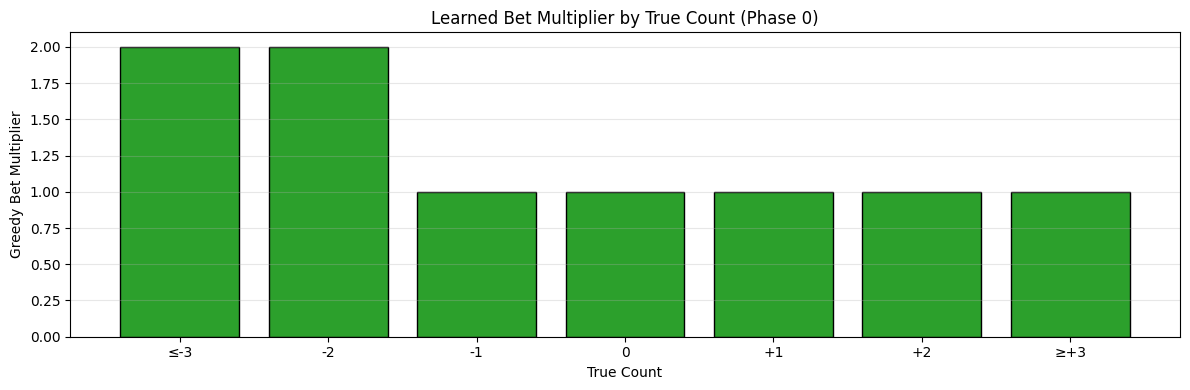

In [8]:
# Extract learned bet multiplier per true count (phase 0) and visualize
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Helper: argmax with deterministic tie-break (first max)
def _argmax(q: np.ndarray) -> int:
    return int(np.argmax(q))

base_env = getattr(env, 'unwrapped', env)
# Determine labels that match the number of TC buckets
n_buckets = int(base_env.observation_space.spaces[3].n)
n_bets = int(getattr(base_env, 'n_bets', 2))
maybe_names = getattr(base_env, 'tc_bucket_names', None)
if maybe_names is not None and len(maybe_names) == n_buckets:
    labels = np.array(list(maybe_names))  # pretty string labels (e.g., "≤-3".."≥+3")
else:
    labels = np.arange(int(base_env.tc_min), int(base_env.tc_max) + 1)

rows = []
for idx in range(n_buckets):
    # Phase-0 observation: before any cards are dealt
    s0 = (0, 0, 0, idx, 0)
    # Use the dedicated betting Q-table for this TC bucket
    q_bets = np.asarray(agent.Q_bet[idx], dtype=float)
    best = _argmax(q_bets)
    mult = float(base_env.bet_multipliers[best])
    visits = (hist_start[idx] if 'hist_start' in globals() else np.nan)
    rows.append({
        'TC_idx': int(idx),
        'TC': labels[idx],
        'best_bet_action': int(best),
        'bet_multiplier': mult,
        'visits_at_start': int(visits) if not np.isnan(visits) else None,
        'Q_bets': q_bets.copy(),
    })

bet_df = pd.DataFrame(rows).sort_values('TC_idx').reset_index(drop=True)
display(bet_df)

# Bar chart of chosen multiplier vs TC (optionally filter low-visit buckets)
min_visits = 0  # set to e.g. 1000 to hide low-data bins
plot_df = bet_df
if 'hist_start' in globals() and min_visits > 0:
    plot_df = bet_df[bet_df['visits_at_start'].fillna(0) >= min_visits]

plt.figure(figsize=(12, 4))
plt.bar(plot_df['TC'], plot_df['bet_multiplier'], color='tab:green', edgecolor='k')
plt.xlabel('True Count')
plt.ylabel('Greedy Bet Multiplier')
plt.title('Learned Bet Multiplier by True Count (Phase 0)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()